In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/dataSet.csv")

In [3]:
df.shape

(9000, 2)

In [4]:
df.head()

,Comment,Label
0,"মুভির ট্রেলার দেখে ভালোই লেগেছে, তবে কিছু কিছু...",2.0
1,"কিছু দৃশ্য খুব ভালো ছিল, কিন্তু চরিত্রগুলোর মধ...",2.0
2,"অভিনয় মোটামুটি ভালো, তবে প্রডাকশন ভীষণ ভালো হত...",2.0
3,"গল্পটা ঠিকঠাক, তবে কিছু জায়গায় লম্বা মনে হয়েছে।",2.0
4,"সুরের সাথে সাথে দৃশ্যগুলোও ভালো লেগেছে, তবে কি...",2.0


In [5]:
df.describe()

,Label
count,9000.000000
mean,1.000000
std,0.816542
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  9000 non-null   object 
 1   Label    9000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.8+ KB


In [7]:
df['Label'] = df['Label'].replace({0.0 : 'Negative', 1.0 : 'Positive', 2.0 : 'Neutral'})

In [8]:
df.head()

,Comment,Label
0,"মুভির ট্রেলার দেখে ভালোই লেগেছে, তবে কিছু কিছু...",Neutral
1,"কিছু দৃশ্য খুব ভালো ছিল, কিন্তু চরিত্রগুলোর মধ...",Neutral
2,"অভিনয় মোটামুটি ভালো, তবে প্রডাকশন ভীষণ ভালো হত...",Neutral
3,"গল্পটা ঠিকঠাক, তবে কিছু জায়গায় লম্বা মনে হয়েছে।",Neutral
4,"সুরের সাথে সাথে দৃশ্যগুলোও ভালো লেগেছে, তবে কি...",Neutral


In [9]:
# from wordcloud import WordCloud

In [10]:
# import matplotlib.pyplot as plt

# text = text = " ".join(df["Comment"])
# wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.title("Word Cloud of Bengali Movie Reviews")
# plt.show()

In [11]:
# import seaborn as sns

# df["review_length"] = df["Label"].dropna().apply(lambda x: len(x.split()))

# plt.figure(figsize=(8, 5))
# sns.histplot(df["review_length"], bins=30, kde=True, color="blue")
# plt.xlabel("Number of Words in Review")
# plt.ylabel("Frequency")
# plt.title("Histogram of Review Lengths")
# plt.show()

In [12]:
X = df['Comment']
y = df['Label']

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_en = le.fit_transform(y)

In [14]:
from datasets import Dataset

data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_en}))
data = data.train_test_split(test_size=0.2, seed=42)

c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [16]:
device = torch.device('cuda')
model_name = 'bert-base-uncased'

In [17]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [18]:
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

In [19]:
data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text'])
data = data.rename_column('label', 'labels')
data.set_format('torch')

Map: 100%|██████████| 1800/1800 [00:00<00:00, 6155.69 examples/s]


In [20]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
)

C:\Users\USERAS\AppData\Local\Temp\ipykernel_38752\423240356.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.755100,0.672247
2,0.616300,0.583195
3,0.534800,0.580074
4,0.421000,0.596683
5,0.316200,0.599580
6,0.268100,0.624794
7,0.241700,0.654458
8,0.313000,0.663188
9,0.338000,0.718709
10,0.190400,0.732801


TrainOutput(global_step=4500, training_loss=0.4329230899016062, metrics={'train_runtime': 1341.9037, 'train_samples_per_second': 53.655, 'train_steps_per_second': 3.353, 'total_flos': 1.8944166076416e+16, 'train_loss': 0.4329230899016062, 'epoch': 10.0})

In [23]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.7328009605407715, 'eval_runtime': 9.6584, 'eval_samples_per_second': 186.367, 'eval_steps_per_second': 11.7, 'epoch': 10.0}


In [24]:
import numpy as np

predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

In [25]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.77      0.69      0.73       594
     Neutral       0.74      0.83      0.78       608
    Positive       0.86      0.84      0.85       598

    accuracy                           0.79      1800
   macro avg       0.79      0.79      0.79      1800
weighted avg       0.79      0.79      0.79      1800



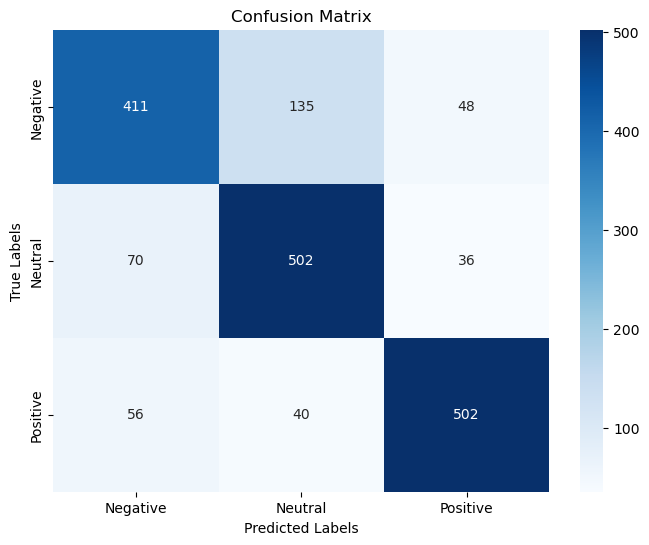

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
def predict(texts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    tokenizer_outputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in tokenizer_outputs.items()}
    outputs = model(**inputs)
    predictions = np.argmax(outputs.logits.cpu().detach().numpy(), axis=1)
    return le.inverse_transform(predictions)

In [28]:
sample_texts = ["আমি তোমাকে ঘৃণা করি"]
predictions = predict(sample_texts)
print(f"Predictions: {predictions}")

Predictions: ['Positive']


In [29]:
sample_texts = ["আমি এটা খুব পছন্দ করেছি"]
predictions = predict(sample_texts)
print(f"Predictions: {predictions}")

Predictions: ['Positive']
